---
# <font color="#CA3532">Práctica 3 de Neurocomputación</font>
### Curso 2021-2022
### Escuela Politécnica Superior – Universidad Autónoma de Madrid

---

Fechas de entrega:
- Grupo 2462: lunes 16 de mayo de 2022
- Grupo 2461: martes 17 de mayo de 2022

---

Última actualización: 31-03-2022

---

*Sesión 1*:

- Esta práctica está centrada en [Keras](https://keras.io/).

- Keras es una biblioteca de redes neuronales de código abierto, diseñada para la experimentación con redes neuronales profundas. Keras es modular, extensible y fácil de usar.

- Keras puede usar distintos motores. Aquí se usará con TensorFlow.



In [2]:
### Incluid vuestros nombres, pareja y grupo aquí:
estudiantes = [{'nombre': 'Diego Cano Rueda', 'pareja': 'P05', 'grupo': '2462'},
               {'nombre': 'Juan Moreno Díez', 'pareja': 'P05', 'grupo': '2462'}]


### <font color="#CA3532">Importación de bibliotecas</font>

TensorFlow 2.0 incluye oficialmente Keras.

In [24]:
# Importaciones

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import keras as k
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend as K

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### <font color="#CA3532">Datos del problema</font>

El problema consiste en predecir si va a haber una erupción solar (*solar flares*) en ciertas regiones solares en función de las características de la región solar. El conjunto datos y la caracterización de sus atributos puede encontrarse en https://www.openml.org/d/40702. El siguiente fragmento de código permite cargar estos datos.

In [35]:
dataset_url = 'https://www.openml.org/data/get_csv/4965303/flare.arff' 

dataset = np.genfromtxt(dataset_url, delimiter=',', skip_header=1)

### -------------------------------------------------------------------------------
### Dividid los ejemplos en atributos y clases. Guardad el número de atributos.
### -------------------------------------------------------------------------------
x = dataset[:,:-1]
x_size = x.shape[1]
y = dataset[:,-1]

Ejemplo 0: [5. 4. 3. 1. 3. 1. 1. 2. 1. 1.] 0.0
Atributos: 10
Clases: [0. 1.]
Recuento de clases: 884 182
Ejemplos: 1066


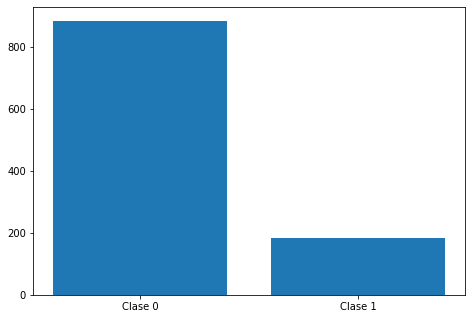

In [36]:
import matplotlib.pyplot as plt

# Resultados de la división y el número de atributos
print('Ejemplo 0:', x[0], y[1])
print('Atributos:', x_size)
print('Clases:', np.unique(y))
print('Recuento de clases:', y.tolist().count(0), y.tolist().count(1))
print('Ejemplos:', len(x))

# código añadido por los alumnos
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
clases = ["Clase 0", "Clase 1"]
ejemplos_clases = [y.tolist().count(0), y.tolist().count(1)]
ax.bar(clases, ejemplos_clases)
plt.show()

Al analizar el diagrama y observar el recuento de ejemplos que pertenecen a cada clase, se puede observar una gran diferencia. Se obtienen muchos más ejemplos de la clase 1, por lo tanto posteriormente tendremos que regularizar esta peculiaridad de los datos.

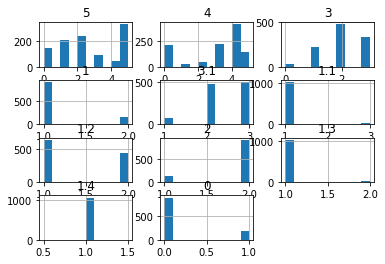

,5,4,3,1,3.1,1.1,1.2,2,1.3,1.4,0
0,1,3,1,1,2,1,1,2,1,1,0
1,2,3,2,1,3,1,1,2,1,1,1
2,5,4,3,2,2,1,2,2,1,1,0
3,1,4,2,1,3,1,1,2,1,1,0
4,1,4,2,1,2,1,2,2,1,1,0
5,2,2,1,1,3,1,2,2,1,1,0
6,2,3,2,1,3,1,1,2,1,1,0
7,0,5,2,1,2,1,1,2,1,1,0
8,2,1,2,1,2,1,2,2,1,1,0
9,3,0,1,2,2,1,2,2,1,1,0


In [37]:
# create pairwise scatter plots of numeric input variables
from pandas import read_csv
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

# load the csv file as a data frame
df = read_csv(dataset_url, header=1)

# histograms of all variables 
df.hist()
pyplot.show()
df.head(10)

Como se puede observar en los datos, los rangos de valores no varían apenas entre los distintos atributos. Por lo tanto no debería ser estrictamente necesario normalizarlos. De todas formas, es bueno normalizar los datos para tener un estándar y a la hora de entrenar y evaluar con las métricas podría darnos mejores resultados.

### <font color="#CA3532">Correlación entre los atributos</font>

A continuación procedemos a mostrar un mapa de calor con las correlaciones entre todos los atributos del problema. Esto nos ayudará más a entender los datos y ver cómo trabajar con ellos posteriormente.

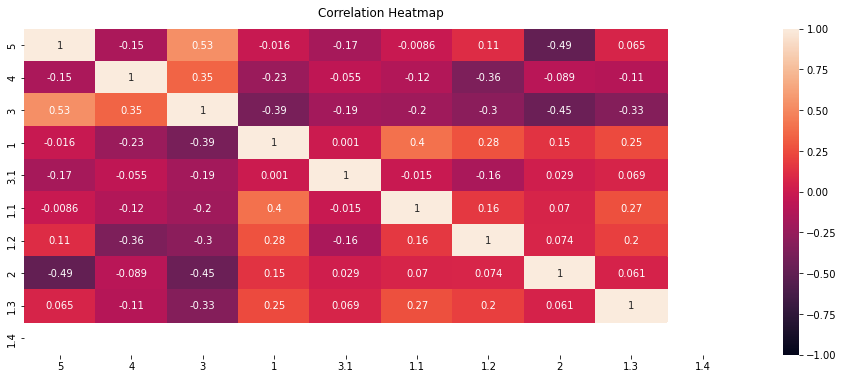

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# drop de la clase
n = 1
df_attrs = df.iloc[:,:-n]

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_attrs.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Al observar el mapa de calor, en la diagonal principal se pueden ver los valores más altos de correlación (1.0); ya que cada atributo está relacionado consigo mismo al 100%. Los demás valores oscilan mayormente entre -0.25 y 0.25. Un punto a descatar sería el atributo 1.4, se puede analizar que no tiene ninguna correlación con ningún otro atributo.

In [39]:
# Normalizad los datos (si es necesario)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

### <font color="#CA3532">Definición del modelo</font>

- Cada capa del modelo lleva definidas una serie de propiedades (tamaño, función de activación, conectividad, etc.). 

- Usaremos el modelo secuencial que Keras para crear una red neuronal multicapa con propagación hacia adelante.



In [29]:
# Definid el modelo con Keras
from keras import regularizers

nn = Sequential()

### -------------------------------------------------------------------------------
### Añadir la capas completamente conectadas que consideréis al modelo
### -------------------------------------------------------------------------------

nn.add(Dense(x_size, input_dim=x_size, activation="sigmoid", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                                             bias_regularizer=regularizers.L2(1e-4),
                                                             activity_regularizer=regularizers.L2(1e-5)))
nn.add(Dropout(.2))
nn.add(Dense(x_size, activation="sigmoid"))
nn.add(Dense(1, activation="sigmoid"))


### <font color="#CA3532">Compilación de la red neuronal</font>

- La compilación es la operación que contruye la red neuronal.

- La compilación incluye aspectos que se tendrán en cuenta en el entrenamiento de la red neuronal.

- En la secciones de abajo encontraréis enlaces a la documentación oficial donde podréis encontrar información sobre las distintas estrategias de cada uno de los aspectos.

- También es posible definid vuestras propias funciones.

#### <font color="#CA3532">Optimizador</font>

El optimizador es la estrategia para calcular las correcciones de los pesos.

https://keras.io/api/optimizers/


#### <font color="#CA3532"> Función de error (*Loss function*)</font>

La función de error calcula la cantidad que el modelo debe minimizar durante el entrenamiento.

https://keras.io/api/losses/

#### <font color="#CA3532">Métricas</font>

Una métrica es una función que juzga la actuación del modelo. Son funciones similares a las funciones de error pero, a diferencia de estas, no se aplican durante el entrenamiento, sino sobre los resultados. Aprende al menos el significado y las diferencias de las métricas *accuracy*, *precision*, *recall* y *AUC*. También pueden usarse las funciones de error como metricas.

https://keras.io/api/metrics/

In [30]:
# Compilación

### -------------------------------------------------------------------------------
### Compilad vuestro modelo de red neuronal
### -------------------------------------------------------------------------------

metrics = [
            #keras.metrics.TruePositives(name='tp'),
            #keras.metrics.FalsePositives(name='fp'),
            #keras.metrics.TrueNegatives(name='tn'),
            #keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.BinaryAccuracy(name='ACC'),
            keras.metrics.Precision(name='Prec'),
            keras.metrics.Recall(name='Rec'),
            keras.metrics.AUC(name='AUC'),
            #keras.metrics.AUC(name='PRC', curve='PR'),
          ]

# nn.compile(optimizer='SGD', loss="mse", metrics=metrics)
nn.compile(optimizer='Adam', loss="binary_crossentropy", metrics=metrics)

### <font color="#CA3532">Conjuntos de entrenamiento y validación</font>

Usaremos el 80 % de los datos para entrenamiento y el 20 % para validación. Usaremos también la técnica de muestreo estratificado (también están permitidas otras formas de validación). Averigua qué es y para qué sirve.

In [11]:
# Contrucción de los conjuntos de entrenamiento y validación

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=0.2) 

### <font color="#CA3532">Visualización de resultados</font>

Para la visualización de los resultados utilizaremos gráficas con la evolución de la función de pérdida y las métricas en cada época del entrenamiento, tanto para los datos de entrenamiento como para los de validación.

También obtendremos la matriz de confusión y alguna métricas sobre cada clase del problema. Observaremos especialmente la medida macro-F1.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def show_metrics(history):
  for metric in history.history.keys():
    if not metric.startswith('val_'):
      plt.plot(history.history[metric], label=metric)
      plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
      plt.title(metric)
      plt.ylabel('')
      plt.xlabel('Epoch')
      plt.legend(loc="upper left")
      plt.show()

### <font color="#CA3532">Entrenamiento de la red neuronal y evaluación</font>

El método "fit" entrena una red neuronal con los datos que se le proporcionen.

https://keras.io/api/models/model_training_apis/#fit-method

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________





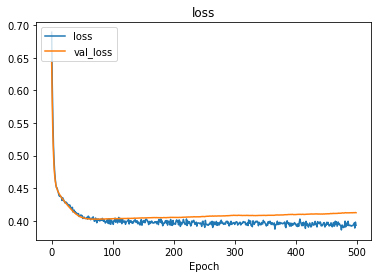

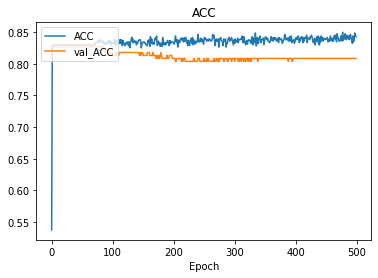

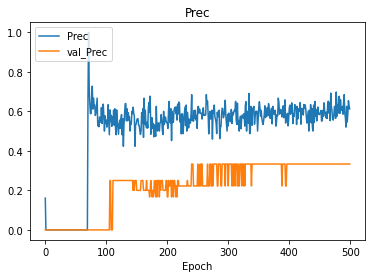

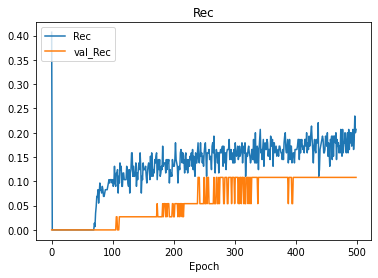

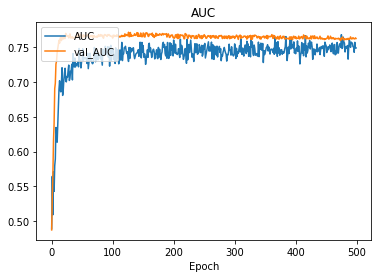

[[169   8]
 [ 33   4]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       177
         1.0       0.33      0.11      0.16        37

    accuracy                           0.81       214
   macro avg       0.58      0.53      0.53       214
weighted avg       0.75      0.81      0.77       214



In [13]:
# Entrenamiento

# subimos las épocas para poder observar 
# mejor las gráficas y comprobar si hay overfitting
epochs = 500

history = nn.fit(x_train, y_train, epochs=epochs, verbose=0, validation_data=(x_val, y_val))

# Predicciones del conjunto de evaluación

y_pred = nn.predict(x_val)
y_pred = y_pred > 0.5

# Detalles de la red neuronal

nn.summary()
print('\n\n')

# Visualización de las métricas 

show_metrics(history)

# Matriz de confusión

print(confusion_matrix(y_val, y_pred))

# Observa la medida macro-f1 del siguiente informe

print(classification_report(y_val, y_pred, zero_division=0))


Al ver las gráficas, se puede apreciar que hay un problema de overfitting (sobreajuste). En las gráficas de precisión y error, el margen que hay entre las curvas de entrenamiento y validación es bastante amplio. Habrá que trabajar con los datos y optimizar el modelo utilizado para que no se produzca este fenómeno. Al añadir la capa de dropout y la regularización se soluciona este problema; al ejecutar quitando estas características del modelo, el margen de las curvas será amplio y al haber añadido lo comentado se puede ver que el problema se soluciona y el margen de las curvas en entrenamiento y validación, se estrecha. También hemos añadido técnicas de regularización para reducir el valor de los parámetros y de esta forma los pesos no se irán a valores demasiado altos que pueden provocar irrelularidades en el modelo. Esta técnica se utiliza para evitar el sobreajuste.

### <font color="#CA3532">Entrenamiento de la red neuronal y evaluación</font>
Como podrás haber observado en problema no está balanceado (o está bastante desequilibrado), porque el número de ejemplos de cada clase es muy diferente.

Existen varias técnicas para abortar este tipo de problemas. Una de ellas consiste seleccionar un subconjunto de datos equilibrados en el que las dos clases esten representadas en la misma proporción.


In [14]:
def plot_diagram(datos_train, datos_val):
  X = ['Entrenamiento','Validacion']
  cont_train = [datos_train.tolist().count(0), datos_val.tolist().count(0)]
  cont_val = [datos_train.tolist().count(1), datos_val.tolist().count(1)]
  X_axis = np.arange(len(X))

  plt.bar(X_axis - 0.2, cont_train, 0.4, label = 'Clase 0')
  plt.bar(X_axis + 0.2, cont_val, 0.4, label = 'Clase 1')

  plt.xticks(X_axis, X)
  plt.xlabel("Conjunto de datos")
  plt.ylabel("Número de ejemplos de cada clase")
  plt.title("Número de clases en cada conjunto de datos")
  plt.legend()
  plt.show()

{0: 0.6025459688826026, 1: 2.9379310344827587}


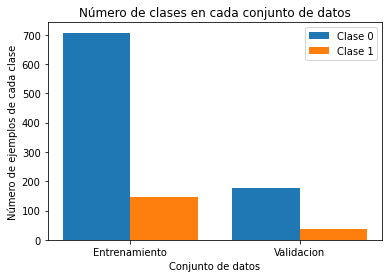

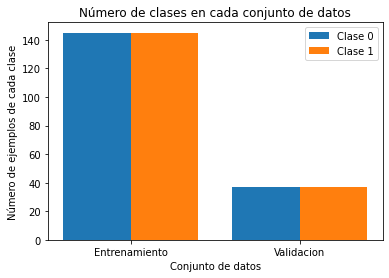

In [15]:
### -------------------------------------------------------------------------------
### Assigna diferentes pesos a cada una de las clases
### -------------------------------------------------------------------------------
# construir subconjunto de datos de mismo número de datos positivos y negativos
#

# pesos para las clases respectivas
# así se haría de forma manual, al imprimir por pantalla
# estos valores, se puede observar que da los mismos 
# resultados que con la libreria sklearn
w0 = x_train.shape[0] / (len(np.unique(y_train)) * y_train.tolist().count(0))
w1 = x_train.shape[0] / (len(np.unique(y_train)) * y_train.tolist().count(1))
class_weights = {0: w0, 1: w1}
print(class_weights)

# número de datos de train con clase = 1
n_train = y_train.tolist().count(1)
# creamos una máscara para aplicarla a las salidas
# de train y así obtenemos una cantidad de índices aleatoria balanceada
mask_train = np.hstack([np.random.choice(np.where(y_train == l)[0], n_train, replace=False)for l in np.unique(y_train)])

# repetimos lo mismo para validacion
n_val = y_val.tolist().count(1)
mask_val = np.hstack([np.random.choice(np.where(y_val == l)[0], n_val, replace=False)for l in np.unique(y_val)])

x_train_balanceado = x_train[mask_train]
y_train_balanceado = y_train[mask_train]

x_val_balanceado = x_val[mask_val]
y_val_balanceado = y_val[mask_val]

plot_diagram(y_train, y_val)
plot_diagram(y_train_balanceado, y_val_balanceado)

Como se puede observar en los diagramas de barras, con los datos de entrenamiento y validación originales, existe mucha diferencia entre el número de ejemplos de las distintas clases. Sin embargo, al aplicar nuestra técnica, hemos conseguido equilibrar los datos igualando el número de ejemplos con respecto a las clases. El único problema es que entrenaremos y realizaremos el test con muchos menos ejemplos; ers bastante probable que el modelo se vaya a sobreajustar.

Vuelve a entrenar con este nuevo conjunto de datos y observa como varía el resultado de la matriz de confusión. Si es posible, intenta conseguir un modelo mejor y describe los resultados alcanzados.

In [16]:
history = nn.fit(x_train_balanceado, y_train_balanceado, epochs=epochs, verbose=0, validation_data=(x_val_balanceado, y_val_balanceado))

# Detalles de la red neuronal

nn.summary()
print('\n\n')

y_pred = nn.predict(x_val_balanceado)
y_pred = y_pred > 0.5

print(classification_report(y_val_balanceado, y_pred, zero_division=0))

print(confusion_matrix(y_val_balanceado, y_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________



              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69        37
         1.0       0.69      0.68      0.68        37

    accuracy           

Como se puede observar, al aplicar el balanceado de los datos, se obtiene una matriz de confusión mucho más balanceada: además las métricas para las dos clases están ahora mucho más igualadas y saca mejores resultados en las métricas para la clase que antes estaba desbalanceada. Para mejorar el rendimiento de la red habrá que posteriormente realizar fine-tuning para escoger los mejores hiperparámetros.

Otra técnica consiste en asignar un peso a cada clase para que lo tenga en cuenta en algoritmo de entrenamiento.
Aprende lo que hace el parámetro ```class_weight``` de ```fit``` (https://keras.io/api/models/model_training_apis/#fit-method) y explícalo.

In [17]:
### -------------------------------------------------------------------------------
### Assigna diferentes pesos a cada una de las clases
### -------------------------------------------------------------------------------

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

print(class_weights)

{0: 0.6025459688826026, 1: 2.9379310344827587}


Vuelve a entrenar considerando distintos pesos y observa como varía el resultado de la matriz de confusión. Si es posible, intenta conseguir un modelo mejor y describe los resultados alcanzados.

In [18]:
history = nn.fit(x_train, y_train, epochs=epochs, verbose=0, class_weight=class_weights, validation_data=(x_val, y_val))

# Detalles de la red neuronal

nn.summary()
print('\n\n')

y_pred = nn.predict(x_val)
y_pred = y_pred > 0.5

print(classification_report(y_val, y_pred, zero_division=0))

print(confusion_matrix(y_val, y_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________



              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85       177
         1.0       0.38      0.59      0.46        37

    accuracy           

Intentamos mejorar el rendimiento añadiendo una capa de dropout al modelo que de forma aleatoria inhabilitará algunas de las neuronas de la arquitectura. Podemos ver que se obtienen mejores resultados en la precisión de los ejemplos de clase 0 y los verdaderos positivos en la matriz de confusión aumentan de forma considerable.

De todas formas, tenemos que tratar de encontra un equilibrio en las precisiones de los ejemplos de ambas clases. Para poder realizar esta tarea más fácilmente, procedemos a realizar la búsqueda de los hiperparámetros que nos lleven a una mejor configuración.

### <font color="#CA3532">Optimización del diseño de la red neuronal</font>

- Cambiad la arquitectura de la red neuronal introduciendo más capas y neuronas para conseguir mejores resultados:
 - Añadid más capas o diferente tipo de capas.
 - Cambiad las funciones de activación.
 - Cambiad la función de error o el optimizador.

- Utilizad ```tuner``` para la búsqueda de estos hiperparámetros (https://keras.io/keras_tuner/).


In [19]:
!pip install -U keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

     |████████████████████████████████| 133 kB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [20]:
# funciones auxiliares para poder incluir el F1 en las métricas

def recall_for_f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tp / (possible + K.epsilon())
    return recall

def precision_for_f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (predicted + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_for_f1(y_true, y_pred)
    recall = recall_for_f1(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
### -------------------------------------------------------
### Define tu hipermodelo
### -------------------------------------------------------

def build_model(hp):
    # serializamos la medida ya que esta no está disponible
    # directaemente en las métricas que ofrece Keras
    serialized_f1 = keras.metrics.serialize(f1)
    # des-serializamos para poder meterla en las métricas
    metrics=[tf.keras.metrics.deserialize(serialized_f1, custom_objects={"f1": f1})]

    nn = Sequential()

    # unidades en la primera capa
    nn.add(Dense(hp.Int('units', min_value=5, max_value=300, step=5), activation=hp.Choice("activation", ["sigmoid", "tanh", "relu"])))

    # para testear número de capas ocultas
    for i in range(hp.Int("num_layers", 1, 3)):
      nn.add(Dense(units=hp.Int(f"units_{i}", min_value=5, max_value=400, step=10), activation=hp.Choice("activation", ["sigmoid", "tanh", "relu"])))

    # capa dropout
    nn.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.6, default=.2, step=0.05)))

    # capa de salida
    nn.add(Dense(1, activation="sigmoid"))
    nn.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=metrics)
    return nn

### -------------------------------------------------------
### Pon en marcha la búsqueda de hiperparámetros, elije el 
### objetivo más adecuado.
### -------------------------------------------------------
# para que no utilize siempre la misma config
!rm -rf untitled_project

# para acabar el entrenamiento antes de alcanzar un valor de pérdida en validación
tuner = RandomSearch(build_model, objective=Objective('val_f1', direction='max'), max_trials=30, executions_per_trial=3) 

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=100, class_weight=class_weights, validation_data=(x_val, y_val), verbose=0)

tuner.results_summary()

best_nn = tuner.get_best_models(num_models=1)
best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print("Mejor número de neuronas para la primera capa: {}".format(best_hyper_parameters.get('units')))
print("Mejor número de capas ocultas: {}".format(best_hyper_parameters.get('num_layers')))

for i in range(0, best_hyper_parameters.get('num_layers')):
  print("Mejor número de neuronas para la capa oculta {}: {}".format(i+1, best_hyper_parameters.get('units_' + str(i))))

print("Mejor valor para la capa de dropout: {}".format(best_hyper_parameters.get('dropout')))
print("Mejor valor para el learning rate: {}".format(best_hyper_parameters.get('learning_rate')))
print("Mejor función de activación: {}".format(best_hyper_parameters.get('activation')))

y_pred = best_nn[0].predict(x_val)
y_pred = y_pred > 0.5

print(confusion_matrix(y_val, y_pred))

print(classification_report(y_val, y_pred, zero_division=0))

Nuestra métrica objetivo será F1 en validación. Tras probar con distintas métricas objetivo (accuacy, recall y f1), hemos comprobado que los mejores resultados y los más equilibrados entre las clases se obtienen cuando ponemos como objetivo el F1. Ya que lo que hace esta métrica es combinar resultados de precisión y recall en un solo resultado. Las pruebas realizadas para comprobar los mejores hiperparámetros son las siguientes:

-------------------- Optimizador ADAM con binary cross entropy --------------------



*   Mejor número de neuronas para la primera capa: 20
*   Mejor número de capas ocultas: 3
  * Mejor número de neuronas para la capa oculta 1: 240
  * Mejor número de neuronas para la capa oculta 2: 10
  * Mejor número de neuronas para la capa oculta 3: 180
*   Mejor valor para la capa de dropout: 0.2
*   Mejor valor para la constante de aprendizaje: 0.001
*   Mejor función de activación: relu

-------------------- Optimizador SGD con mean squared error --------------------



*   Mejor número de neuronas para la primera capa: 20
*   Mejor número de capas ocultas: 3
  * Mejor número de neuronas para la capa oculta 1: 240
  * Mejor número de neuronas para la capa oculta 2: 10
  * Mejor número de neuronas para la capa oculta 3: 80
*   Mejor valor para la capa de dropout: 0.0
*   Mejor valor para la constante de aprendizaje: 0.001
*   Mejor función de activación: relu

Se obtienen mejores resultados en cuanto a métricas y matriz de confusión con el optimizador Adam y binary cross entropy como función de pérdidas.










### <font color="#CA3532">Diseño final de la red neuronal</font>
Define ahora tu modelo final y muestra los resultados de su evaluación.

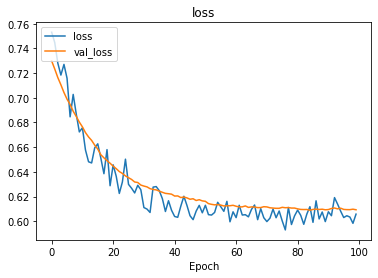

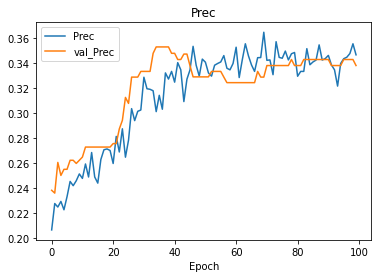

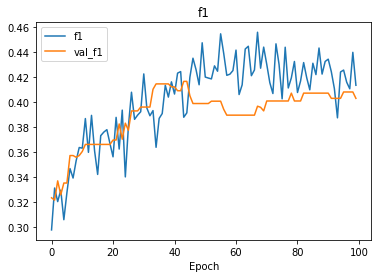

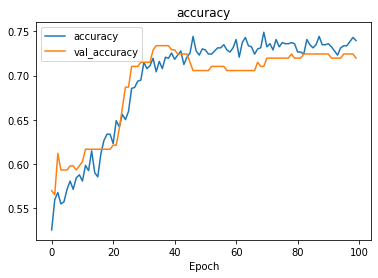

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81       177
         1.0       0.34      0.65      0.44        37

    accuracy                           0.72       214
   macro avg       0.62      0.69      0.63       214
weighted avg       0.81      0.72      0.75       214

[[130  47]
 [ 13  24]]


In [40]:
### ---------------------------------------------------------------------------
### Modelo final y evaluación
### ---------------------------------------------------------------------------

nn_final = Sequential()

serialized_f1 = keras.metrics.serialize(f1)
metrics=[tf.keras.metrics.Precision(name="Prec"), tf.keras.metrics.deserialize(serialized_f1, custom_objects={"f1": f1}), "accuracy"]

# primera capa
tf.keras.layers.Dense(input_dim=x_size, units=20, activation="relu")

# capas ocultas
tf.keras.layers.Dense(units=240, activation="relu")
tf.keras.layers.Dense(units=10, activation="relu")
tf.keras.layers.Dense(units=180, activation="relu")

# capa de dropout
nn_final.add(Dropout(rate=0.2))

# capa de salida
nn_final.add(Dense(1, activation="sigmoid"))

nn_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)

history = nn_final.fit(x_train, y_train, epochs=100, class_weight=class_weights, validation_data=(x_val, y_val), verbose=0)

y_pred = nn_final.predict(x_val)
y_pred = y_pred > 0.5

show_metrics(history)

print(classification_report(y_val, y_pred, zero_division=0))

print(confusion_matrix(y_val, y_pred))

Al haber ejecutado el código anterior probando con el optimizador de Adam + función de error = binary cross entropy y el optimizador SGD con fucnción de error = mse; se comprueba que el sobreaujuste sigue apareciendo con el opitimizador SGD + mse. Sin embargo, al ver las gráficas anteriores, usando Adam + binary cross entropy, el magen de las curvas no es amplio y por lo tanto no se está produciendo sobreauste. A continuación mostraremos el área por debajo de la curva ROC para el modelo que hemos considerado más óptimo.

In [43]:
def plot_AUCROC(ns_fpr, ns_tpr, nn_fpr, nn_tpr):
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(nn_fpr, nn_tpr, marker='.', label='Best Model')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

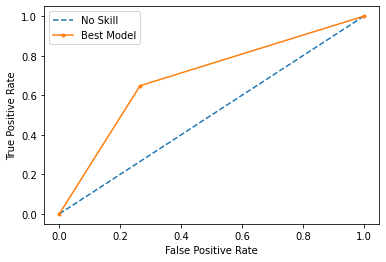

In [44]:
# generar una predicción "no skill" para la clase mayoritaria
ns_probs = [0 for _ in range(len(y_val))]

ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_val, y_pred)

plot_AUCROC(ns_fpr, ns_tpr, nn_fpr, nn_tpr)